# AI Lab Run Boundary Detection

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import random
from sklearn.manifold import TSNE  # Optional: Use t-SNE for dimensionality reduction
import seaborn as sns
from collections import Counter
from tqdm import tqdm

In [2]:
from model_padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from misc_my_utils import *
from model_loss import *
from model_model import SimplerPhxLearnerInit as TheLearner
from model_dataset import WordDatasetBoundary as ThisDataset
from model_dataset import Normalizer, DeNormalizer
from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import DS_Tools
from reshandler import BndEncoderResHandler
from misc_progress_bar import draw_progress_bar
from test_bnd_detect_tools import *
from misc_tools import PathUtils as PU

## Preps

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [4]:
EPOCHS = 10
BATCH_SIZE = 1

INPUT_DIM = 64
OUTPUT_DIM = 64

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

## Prepare for loading Model

In [5]:
ts = "0129210506"
stop_epoch = "79"
train_name = "A_01"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
PU.path_exist(model_save_dir)
print(f"{train_name}-{ts}")

A_01-0129210506


## Load Dataset

In [6]:
TEST = False

In [7]:
mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       transform=mytrans)

valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)


# Load Test set
if TEST: 
    test_ds = ThisDataset(rec_dir, 
                        test_guide_path, 
                        transform=mytrans)
    test_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "test.use"))

    use_test_ds = torch.utils.data.Subset(test_ds, test_ds_indices)

    test_loader = DataLoader(use_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
    test_num = len(test_loader.dataset)

In [8]:
valid_num

10380

## Model

### Model-related defs

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
# model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Load Model

In [10]:
model_name = "{}.pt".format(stop_epoch)
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

SimplerPhxLearnerInit(
  (encoder): RLEncoder(
    (rnn): LSTM(64, 16, num_layers=2, batch_first=True)
    (lin_2): LinearPack(
      (linear): Linear(in_features=16, out_features=8, bias=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): InitRALDecoder(
    (rnn): LSTM(64, 8, num_layers=2, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_3): LinearPack(
      (linear): Linear(in_features=8, out_features=64, bias=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
)

## Inference

In [11]:
def infer(): 
    model.eval()
    reshandler = BndEncoderResHandler(whole_res_dir=model_save_dir, file_prefix="boundary")
    all_res = []
    all_bnd = []
    all_name = []

    for (x, x_lens, bnd, name) in tqdm(valid_loader): 
        bnd = bnd[0]
        name = name[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        hid_r = model.encode(x, x_lens, x_mask)

        hid_r = hid_r.cpu().detach().numpy().squeeze()

        length = hid_r.shape[0]

        all_res += [hid_r]
        # note that this is bit different, not each frame, but each sequence is treated as one data point
        all_bnd += [bnd]
        all_name += [name]
    

    reshandler.res = all_res
    reshandler.tok = all_bnd
    reshandler.name = all_name
    reshandler.save()

In [12]:
if __name__ == "__main__": 
    infer()

100%|██████████| 10380/10380 [00:29<00:00, 356.26it/s]


# Load Res

In [13]:
reshandler = BndEncoderResHandler(whole_res_dir=model_save_dir, file_prefix="boundary")
reshandler.read()

# Evaluate with Wang et al. method

In [14]:
# all
all_preds = reshandler.res
all_bnds = reshandler.tok
# all_matching_status = reshandler.match_status

In [15]:
one_counter = 0
total_counter = 0

for bnd in all_bnds: 
    if len(bnd) <= 1: 
        one_counter += 1
    total_counter += 1

print(one_counter, total_counter, one_counter/total_counter)

415 10380 0.03998073217726397


In [16]:
# one_bound_out: bnds excludes last
preds = []
bnds = []
for idx in range(len(all_preds)): 
    if len(all_bnds[idx]) <= 1: 
        continue
    preds.append(all_preds[idx])
    bnds.append(all_bnds[idx][:-1])

In [17]:
len(bnds)

9965

In [18]:
periodic_preds = periodic_bnd_detect(preds, every=4, only_then_rand=False)

In [19]:
pb_precision_list, pb_recall_list = [], []

#Recall
for i in range(len(bnds)):
    single_utt_recall = tolerance_recall(bnds[i], \
                            periodic_preds[i], tolerance_window=2)
    pb_recall_list.append(single_utt_recall)

#Precision
for i in range(len(periodic_preds)):
    single_utt_precision = tolerance_precision(bnds[i], \
                            periodic_preds[i], tolerance_window=2)
    pb_precision_list.append(single_utt_precision)


precision = sum(pb_precision_list) / len(pb_precision_list)
recall = sum(pb_recall_list) / len(pb_recall_list)
recall *= 100
precision *= 100
if recall == 0. or precision == 0.:
    f_score = -1.
    r_val = -1.
else:
    f_score = (2 * precision * recall) / (precision + recall)
    r_val = r_val_eval(precision, recall)

print("R-value for periodic boundary prediction is: {}".format(r_val))

R-value for periodic boundary prediction is: 34.74765222111766


## Run a through search through all dims

In [20]:
dims = list(range(8)) + ["mean"]
th = [0.1, 0.08, 0.06, 0.05, 0.04, 0.035, 0.03]
th += [0.029, 0.028, 0.027, 0.026, 0.025, 0.024, 0.023, 0.022, 0.021, 0.02, 0.019]
th += [0.018, 0.017, 0.016, 0.015, 0.014, 0.013, 0.012, 0.011, 0.01]
th += [0.0008, 0.0007]
th_total = len(th)

recall_lslsls, precision_lslsls, r_val_lslsls = [], [], []

for idx, dim in enumerate(dims): 
    recall_lsls, precision_lsls, r_val_ls = [], [], []
    
    for idx, thresh in enumerate(th): 
        recall_list, precision_list = thresh_segmentation_eval(batch_delta_hrs(preds, sel=dim, minus=True), bnds, tolerance_window=2, diff_thresh_factor=thresh)
        recall_lsls.append(recall_list)
        precision_lsls.append(precision_list)

    for th_idx in range(len(th)): 
        precision_list = precision_lsls[th_idx]
        recall_list = recall_lsls[th_idx]

        precision = sum(precision_list) / len(precision_list)
        recall = sum(recall_list) / len(recall_list)
        recall *= 100
        precision *= 100
        if recall == 0. or precision == 0.:
            f_score = -1.
            r_val = -1.
        else:
            f_score = (2 * precision * recall) / (precision + recall)
            r_val = r_val_eval(precision, recall)
        
        r_val_ls.append(r_val)
    
    recall_lslsls.append(recall_lsls)
    precision_lslsls.append(precision_lsls)
    r_val_lslsls.append(r_val_ls)
    
    print('The best r_val is: {:.4f}, th = {}, dim = {}'.format(max(r_val_ls), th[r_val_ls.index(max(r_val_ls))], dim))

The best r_val is: 58.5573, th = 0.01, dim = 0
The best r_val is: 57.3472, th = 0.1, dim = 1
The best r_val is: 59.1936, th = 0.1, dim = 2
The best r_val is: 46.6594, th = 0.0007, dim = 3
The best r_val is: 59.5848, th = 0.029, dim = 4
The best r_val is: 55.2367, th = 0.0007, dim = 5
The best r_val is: 51.7491, th = 0.0008, dim = 6
The best r_val is: 57.6581, th = 0.011, dim = 7
The best r_val is: 58.1343, th = 0.025, dim = mean


In [59]:
# Plus
"""
The best r_val is: 64.1704, th = 0.027, dim = 0
The best r_val is: 29.5702, th = 0.0008, dim = 1
The best r_val is: 62.8208, th = 0.019, dim = 2
The best r_val is: 64.6059, th = 0.03, dim = 3
The best r_val is: 49.6899, th = 0.003, dim = 4
The best r_val is: 67.6130, th = 0.008, dim = 5
The best r_val is: 35.5558, th = 0.0008, dim = 6
The best r_val is: 63.5690, th = 0.022, dim = 7
The best r_val is: 55.5981, th = 0.0008, dim = mean
"""

# Minus
"""
The best r_val is: 65.9907, th = 0.024, dim = 0
The best r_val is: 51.9334, th = 0.035, dim = 1
The best r_val is: 62.7616, th = 0.01, dim = 2
The best r_val is: 65.6081, th = 0.03, dim = 3
The best r_val is: 49.1389, th = 0.0008, dim = 4
The best r_val is: 65.7445, th = 0.01, dim = 5
The best r_val is: 65.8716, th = 0.027, dim = 6
The best r_val is: 63.0764, th = 0.019, dim = 7
The best r_val is: 66.7116, th = 0.027, dim = mean
"""


"""
The best r_val is: 64.1667, th = 0.028, dim = 0
The best r_val is: 29.5675, th = 0.001, dim = 1
The best r_val is: 62.7918, th = 0.02, dim = 2
The best r_val is: 64.6059, th = 0.03, dim = 3
The best r_val is: 49.6220, th = 0.004, dim = 4
The best r_val is: 67.6130, th = 0.008, dim = 5
The best r_val is: 35.5199, th = 0.001, dim = 6
The best r_val is: 63.5690, th = 0.022, dim = 7
The best r_val is: 55.5489, th = 0.001, dim = mean
"""

'\nThe best r_val is: 64.1667, th = 0.028, dim = 0\nThe best r_val is: 29.5675, th = 0.001, dim = 1\nThe best r_val is: 62.7918, th = 0.02, dim = 2\nThe best r_val is: 64.6059, th = 0.03, dim = 3\nThe best r_val is: 49.6220, th = 0.004, dim = 4\nThe best r_val is: 67.6130, th = 0.008, dim = 5\nThe best r_val is: 35.5199, th = 0.001, dim = 6\nThe best r_val is: 63.5690, th = 0.022, dim = 7\nThe best r_val is: 55.5489, th = 0.001, dim = mean\n'

# Plot some hidrep graphs in relation to boundary

In [21]:
def plot_feature_with_boundaries(features, boundaries, name):
    num_features = features.shape[1]
    num_samples = features.shape[0]


    time_axis = np.arange(num_samples)

    fig, axes = plt.subplots(num_features + 1, 1, figsize=(10, (num_features + 1) * 2), sharex=True)

    # Plot each feature on separate subplots
    for i in range(num_features):
        ax = axes[i]
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}')

        for boundary in boundaries:
            if boundary < num_samples:
                ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

        ax.set_ylabel(f'Feature {i + 1}')

    # Plot all dimensions together with different line colors
    ax = axes[num_features]
    for i in range(num_features):
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}', alpha=0.5)

    for boundary in boundaries:
        if boundary < num_samples:
            ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    ax.set_ylabel('All Features')
    ax.legend()

    plt.xlabel('Time (frames)')

    plt.tight_layout()
    # plt.show()
    plt.savefig("./8dim_hrs/" + "{}_dim.png".format(name))
    plt.close()

In [22]:
def plot_mean_feature_with_boundaries(features, boundaries, name):
    """
    Plot the mean of the features as a line graph with marked boundaries.
    
    Parameters:
    - features: NumPy array of shape (length, 8)
    - boundaries: List of boundary times (frame numbers)
    """
    num_samples = features.shape[0]

    # Create a time axis
    time_axis = np.arange(num_samples)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, features, label='Mean Feature')

    # Mark boundaries on the plot
    for boundary in boundaries:
        if boundary < num_samples:
            plt.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    # Set labels and legend
    plt.xlabel('Time (frames)')
    plt.ylabel('Mean Feature Value')
    plt.legend()
    
    # plt.show()
    plt.savefig("./8dim_hrs/" + "{}_mean.png".format(name))
    plt.close()

In [23]:
def plot_all_and_mean_feature_with_boundaries(features, mean_features, boundaries, name):
    """
    Plot the mean of the features as a line graph with marked boundaries.
    
    Parameters:
    - features: NumPy array of shape (length, 8)
    - boundaries: List of boundary times (frame numbers)
    """
    num_features = features.shape[1]
    num_samples = features.shape[0]

    # Create a time axis
    time_axis = np.arange(num_samples)

    # Create the plot
    # plt.figure(figsize=(10, 6))
    fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
    # Plot all dimensions together with different line colors

    ax = axes[0]
    ax.plot(time_axis, mean_features, label='Mean Feature')

    # Mark boundaries on the plot
    for boundary in boundaries:
        if boundary < num_samples:
            ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    ax.set_ylabel('Mean Feature Value')

    ax = axes[1]
    for i in range(num_features):
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}', alpha=0.5)

    for boundary in boundaries:
        if boundary < num_samples:
            ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)
    
    ax.set_ylabel('All Features')
    # ax.legend(loc="best")

    # Set labels and legend
    plt.xlabel('Time (frames)')
    
    # plt.legend(pos="out")
    
    plt.show()
    # plt.savefig("./8dim_hrs/" + "{}_mean.png".format(name))
    # plt.close()

In [26]:
spec_idx = reshandler.name.index("2007-149877-0008-0017")

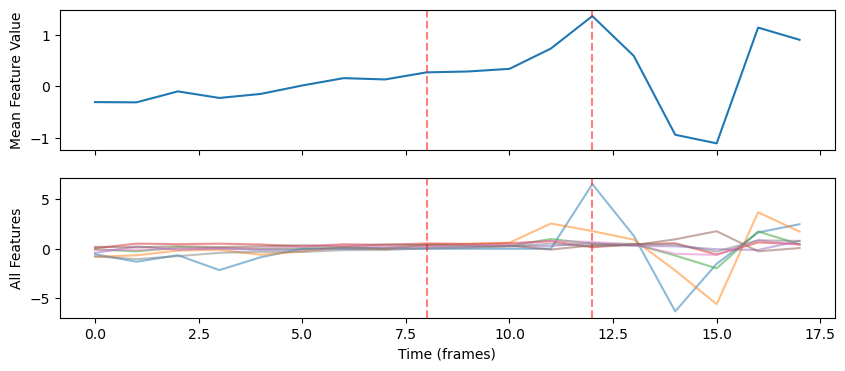

In [27]:
name = reshandler.name[spec_idx]
pred = reshandler.res[spec_idx]
bnd = reshandler.tok[spec_idx]

delta = delta_hrs(pred)
pred_mean = pred.mean(axis=1)
delta_mean = delta_hrs(pred_mean)
# delta = pred
plot_all_and_mean_feature_with_boundaries(delta, delta_mean, bnd, name)

In [23]:
mk("./8dim_hrs")

In [24]:
total_len = len(reshandler.name)

In [26]:
spec_idx = reshandler.name.index("s0502a_00000395")

In [27]:
name = reshandler.name[spec_idx]
pred = reshandler.res[spec_idx]
bnd = reshandler.tok[spec_idx]

delta = delta_hrs(pred)
# delta = pred
plot_feature_with_boundaries(delta, bnd, name)

pred_mean = pred.mean(axis=1)
delta = delta_hrs(pred_mean)
# delta = pred_mean
plot_mean_feature_with_boundaries(delta, bnd, name)

In [25]:
for i in range(20): 
    randidx = random.randint(0, total_len)
    name = reshandler.name[randidx]
    pred = reshandler.res[randidx]
    bnd = reshandler.tok[randidx]

    # delta = delta_hrs(pred)
    delta = pred
    plot_feature_with_boundaries(delta, bnd, name)

    pred_mean = pred.mean(axis=1)
    # delta = delta_hrs(pred_mean)
    delta = pred_mean
    plot_mean_feature_with_boundaries(delta, bnd, name)